In [1]:
import sys
root_dir_abspath = '/home/adnen.boumessouer/Anomaly_Detection'

In [2]:
sys.path.insert(0, root_dir_abspath)

In [3]:
import os

import numpy as np
import pandas as pd
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt

from modules.resmaps import calculate_resmaps
from modules.cv import threshold_images
from modules.cv import label_images

from modules.utils import printProgressBar
from modules.utils import load_model_HDF5

import time

from sklearn.metrics import confusion_matrix
from modules import utils as utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [4]:
def plot_image(image, cmap="inferno", title=None):
    fig, ax = plt.subplots(figsize=(5, 3))
    im = ax.imshow(image, cmap=cmap)
    ax.set_axis_off()
    fig.colorbar(im)
    plt.title(title)
    plt.show()

## Load arrays
to create these arrays, you either need to have run `train.py` with `--inspect` flag, or run `validation.py` and `test.py` (with dummy `area` and `threshold` arguments) and set the `--save` flag for both.

### Load validation and test (input and pred) images

In [5]:
# change model_dir to try another model 
model_dir = "saved_models/mvtec/cable/mvtec2/SSIM/28-04-2020_08-05-06"

model_abs_path = os.path.join(root_dir_abspath, model_dir)

# change paths if input and pred images are not stored in .../instection
path_val_input = os.path.join(model_abs_path, "inspection_val/imgs_val_input.npy")
path_val_pred = os.path.join(model_abs_path, "inspection_val/imgs_val_pred.npy")

imgs_val_input = np.load(path_val_input, allow_pickle=True)
imgs_val_pred = np.load(path_val_pred, allow_pickle=True)

path_test_input = os.path.join(model_abs_path, "inspection_test/imgs_test_input.npy")
path_test_pred = os.path.join(model_abs_path, "inspection_test/imgs_test_pred.npy")

imgs_test_input = np.load(path_test_input, allow_pickle=True)
imgs_test_pred = np.load(path_test_pred, allow_pickle=True)

## Calculate Resmaps

In [6]:
resmaps_val_ssim = calculate_resmaps(imgs_val_input, imgs_val_pred, method="SSIM")
resmaps_val = img_as_ubyte(resmaps_val_ssim)

resmaps_test_ssim = calculate_resmaps(imgs_test_input, imgs_test_pred, method="SSIM")
resmaps_test = img_as_ubyte(resmaps_test_ssim)

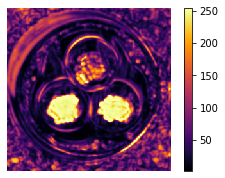

In [7]:
index_val = 0
plot_image(resmaps_val[index_val,:,:,0])

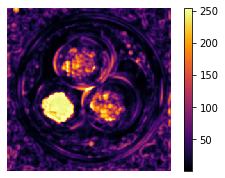

In [9]:
index_test = 63
plot_image(resmaps_test[index_test,:,:,0])

# Determine a good value of `min_area` input argument for validation algorithm (`validation.py`)

## Get basic stats on number of anomalous regions as well as their sum, mean and std size with increasing thresholds

In [10]:
def get_stats(resmaps, th_min=128, th_max=255, plot=False):
    
    dict_stat = {
        "threshold": [],
        "nb_regions": [],
        "mean_areas_size": [],
        "std_areas_size": [],
        "sum_areas_size": [],
    }

    # compute and plot number of anomalous regions and their area sizes with increasing thresholds
    print("computing anomalous regions and area sizes with increasing thresholds...")
    for threshold in range(th_min, th_max + 1):
        # threshold residual maps
        resmaps_th = threshold_images(resmaps, threshold)[:,:,:,0]

        # compute anomalous regions and their size for current threshold
        resmaps_labeled, areas_all = label_images(resmaps_th)
        areas_all_1d = [item for sublist in areas_all for item in sublist]

        # compute the size of the biggest anomalous region (corresponds with smallest threshold)
        if threshold == th_min:
            max_region_size = np.amax(np.array(areas_all_1d))

        nb_regions = len(areas_all_1d)
        if nb_regions == 0:
            break

        mean_areas_size = np.mean(areas_all_1d)
        std_areas_size = np.std(areas_all_1d)
        sum_areas_size = np.sum(areas_all_1d)

        # append values to dictionnary
        dict_stat["threshold"].append(threshold)
        dict_stat["nb_regions"].append(nb_regions)
        dict_stat["mean_areas_size"].append(mean_areas_size)
        dict_stat["std_areas_size"].append(std_areas_size)
        dict_stat["sum_areas_size"].append(sum_areas_size)
        
    df_stat = pd.DataFrame.from_dict(dict_stat)
    
    if plot:
        fig = plt.figure(figsize=(12,8))
        plt.style.use("seaborn-darkgrid")
        ax1 = fig.add_subplot(111)
        lns1 = ax1.plot(df_stat.threshold, df_stat.mean_areas_size, "C0", label="mean_areas_size") #1f77b4
        lns2 = ax1.plot(df_stat.threshold, df_stat.std_areas_size, "C1", label="std_areas_size")
        ax1.set_xlabel("Thresholds")
        ax1.set_ylabel("areas size [number of pixels]")
    
        ax2 = ax1.twinx()
        lns3 = ax2.plot(df_stat.threshold, df_stat.nb_regions, "C2", label="nb_regions") #ff7f0e
        ax2.set_ylabel("number of anomalous regions", color="C2")
        for tl in ax2.get_yticklabels():
            tl.set_color("C2")
        
        lns = lns1+lns2+lns3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc=0)
        
        plt.show()
    
    return df_stat

### Validation stats

computing anomalous regions and area sizes with increasing thresholds...


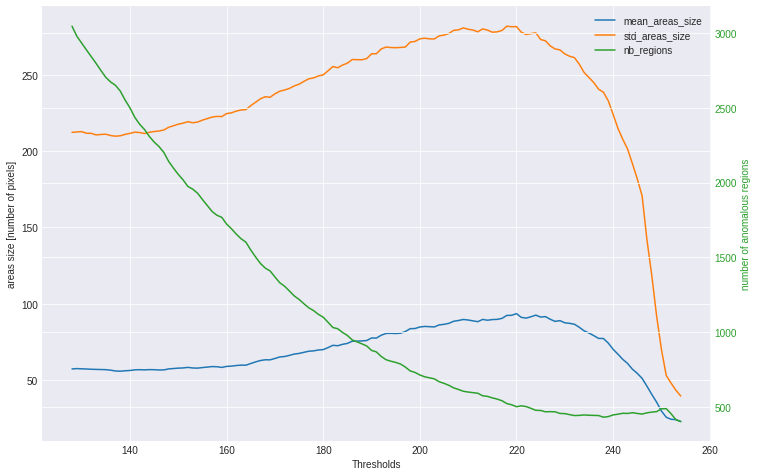

In [11]:
df_stat_val = get_stats(resmaps_val, th_min=128, th_max=255, plot=True)

In [12]:
df_stat_val

,threshold,nb_regions,mean_areas_size,std_areas_size,sum_areas_size
0,128,3045,57.333333,212.289170,174580
1,129,2978,57.558764,212.569546,171410
2,130,2932,57.425307,212.775550,168371
3,131,2886,57.287249,211.712955,165331
4,132,2841,57.140795,211.640963,162337
...,...,...,...,...,...
122,250,489,29.797546,70.163277,14571
123,251,490,25.695918,53.070221,12591
124,252,456,24.344298,48.036329,11101
125,253,416,24.153846,43.373272,10048


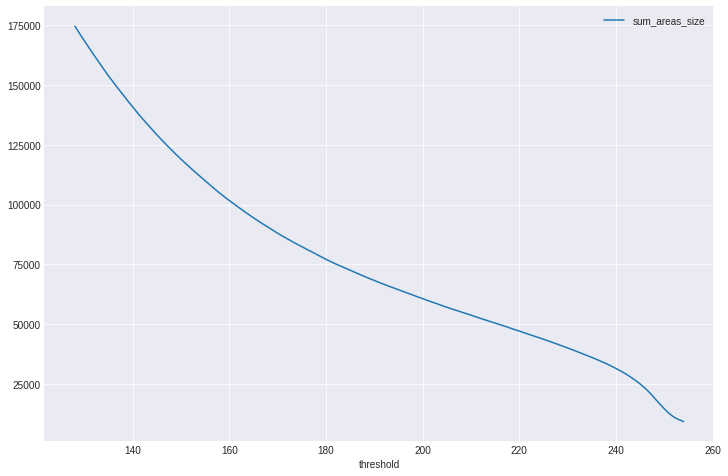

In [13]:
df_stat_val.plot(x="threshold", y=["sum_areas_size"], figsize=(12,8))

### Test stats

computing anomalous regions and area sizes with increasing thresholds...


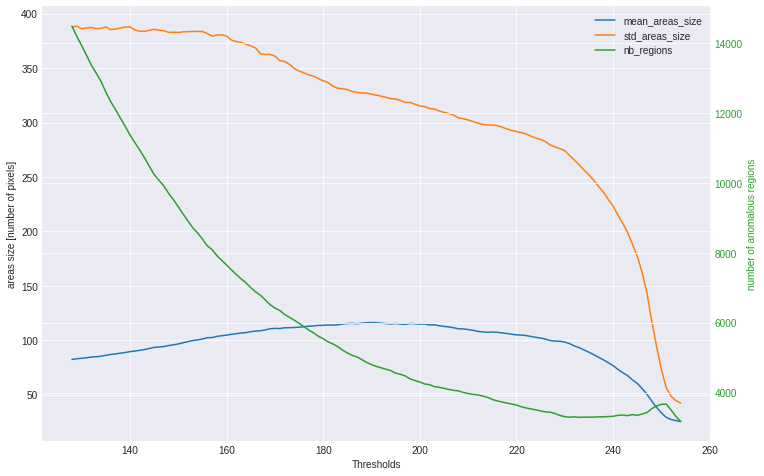

In [14]:
df_stat_test = get_stats(resmaps_test, th_min=128, th_max=255, plot=True)

In [15]:
df_stat_test

,threshold,nb_regions,mean_areas_size,std_areas_size,sum_areas_size
0,128,14486,82.454991,387.910037,1194443
1,129,14192,83.008596,388.511143,1178058
2,130,13929,83.431474,386.084161,1162117
3,131,13655,83.959063,386.837725,1146461
4,132,13369,84.580298,387.335820,1130754
...,...,...,...,...,...
122,250,3660,33.281694,73.170156,121811
123,251,3668,29.192748,56.467535,107079
124,252,3500,27.213143,48.566705,95246
125,253,3316,26.176417,44.446373,86801


# Comparison of validation and test Resmaps statistics

###  Merge validation and test DataFrames

In [16]:
# merge df_stats_val with df_stats_test and plot to see difference
mapper_val = {"nb_regions":"nb_regions_val", "mean_areas_size":"mean_areas_size_val", "std_areas_size":"std_areas_size_val", "sum_areas_size":"sum_areas_size_val"}
mapper_test = {"nb_regions":"nb_regions_test", "mean_areas_size":"mean_areas_size_test", "std_areas_size":"std_areas_size_test", "sum_areas_size":"sum_areas_size_test"}
df_stat_val_new = df_stat_val.rename(columns=mapper_val, copy=True)
df_stat_test_new = df_stat_test.rename(columns=mapper_test, copy=True)

In [17]:
df_stat = pd.concat([df_stat_val_new, df_stat_test_new.drop(["threshold"], axis=1)], axis=1, sort=False, join="outer")

In [18]:
df_stat

,threshold,nb_regions_val,mean_areas_size_val,std_areas_size_val,sum_areas_size_val,nb_regions_test,mean_areas_size_test,std_areas_size_test,sum_areas_size_test
0,128,3045,57.333333,212.289170,174580,14486,82.454991,387.910037,1194443
1,129,2978,57.558764,212.569546,171410,14192,83.008596,388.511143,1178058
2,130,2932,57.425307,212.775550,168371,13929,83.431474,386.084161,1162117
3,131,2886,57.287249,211.712955,165331,13655,83.959063,386.837725,1146461
4,132,2841,57.140795,211.640963,162337,13369,84.580298,387.335820,1130754
...,...,...,...,...,...,...,...,...,...
122,250,489,29.797546,70.163277,14571,3660,33.281694,73.170156,121811
123,251,490,25.695918,53.070221,12591,3668,29.192748,56.467535,107079
124,252,456,24.344298,48.036329,11101,3500,27.213143,48.566705,95246
125,253,416,24.153846,43.373272,10048,3316,26.176417,44.446373,86801


### Scale `nb_of_regions` and `sum_area_size` attributes in test DataFrame to be able to compare with those of validation

The number of validation images is 21, whereas the number of test images is equal to 132. 
This means that we must first normalize the test features of `df_stat` that depend on the number of instances, i.e `nb_of_regions` and `sum_area_size`.

In [19]:
scale_ratio = len(resmaps_val)/len(resmaps_test)
df_stat["nb_regions_test"] = df_stat["nb_regions_test"].map(lambda value: np.ceil(scale_ratio*value))
df_stat["sum_areas_size_test"] = df_stat["sum_areas_size_test"].map(lambda value: np.ceil(scale_ratio*value))

### Plot validation and test statistics

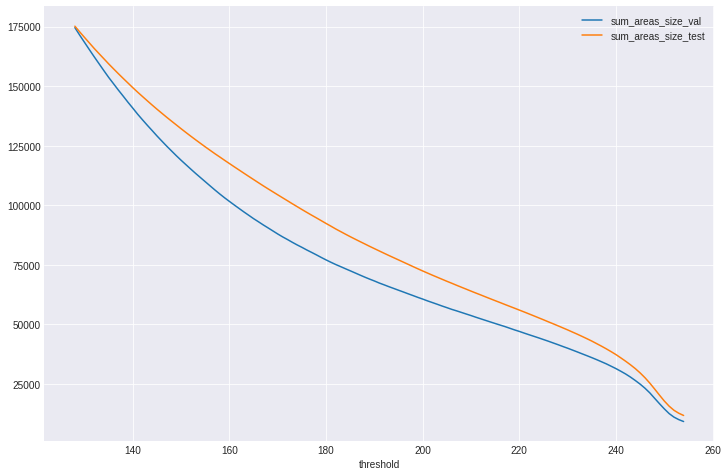

In [20]:
df_stat.plot(x="threshold", y=["sum_areas_size_val", "sum_areas_size_test"], figsize=(12,8))

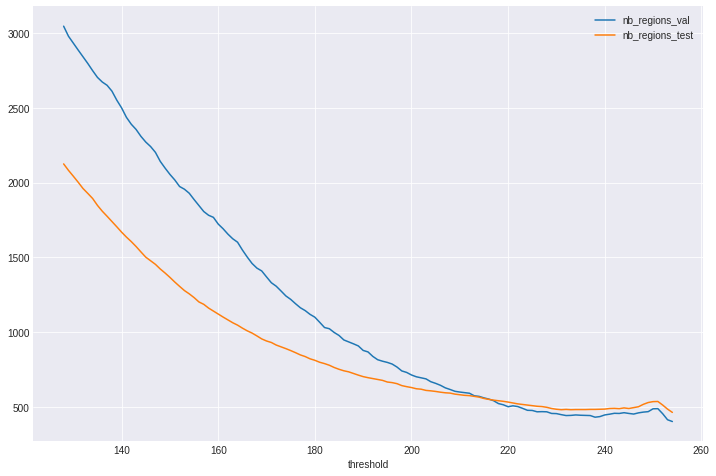

In [21]:
df_stat.plot(x="threshold", y=["nb_regions_val", "nb_regions_test"], figsize=(12,8))

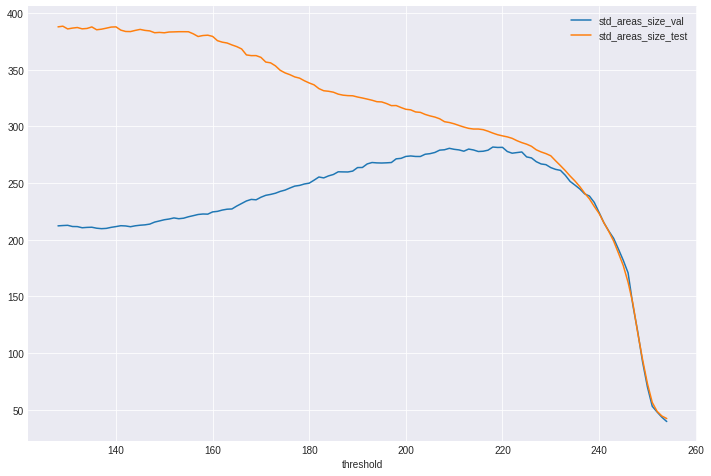

In [22]:
df_stat.plot(x="threshold", y=["std_areas_size_val", "std_areas_size_test"], figsize=(12,8))

### Inspect selected interval

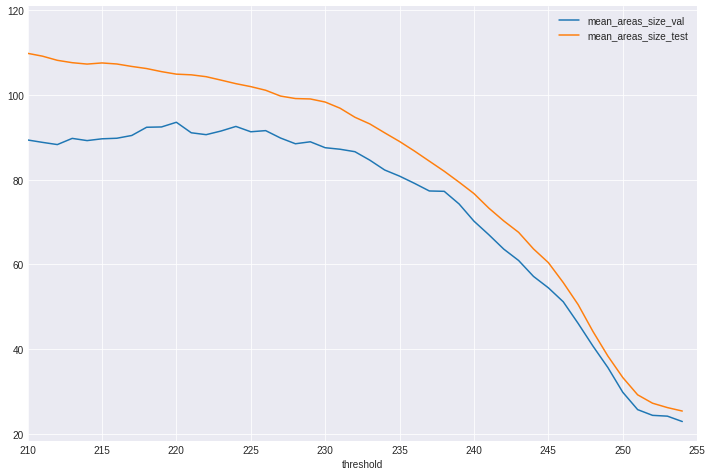

In [23]:
interval = (210,255)
df_stat.plot(x="threshold", y=["mean_areas_size_val", "mean_areas_size_test"], xlim=interval, figsize=(12,8))

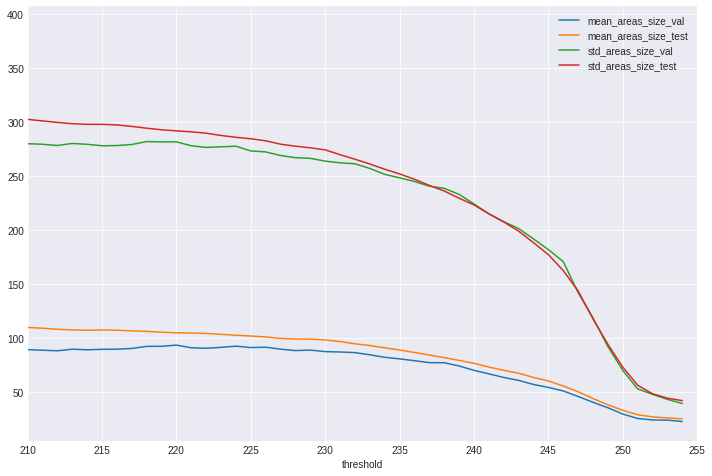

In [24]:
df_stat.plot(x="threshold", y=["mean_areas_size_val", "mean_areas_size_test", "std_areas_size_val", "std_areas_size_test"], xlim=interval, figsize=(12,8))

### Approximate a good value for `min_area`

In [25]:
df_stat[(df_stat["threshold"] >= 210) & (df_stat["nb_regions_val"]>1)][["mean_areas_size_val", "std_areas_size_val", "nb_regions_val"]]

,mean_areas_size_val,std_areas_size_val,nb_regions_val
82,89.389351,279.850450,601
83,88.824121,279.320144,597
84,88.301855,278.178340,593
85,89.763889,280.060373,576
86,89.241259,279.274155,572
87,89.663701,277.909268,562
88,89.796029,278.140732,554
89,90.449355,279.067351,543
90,92.391221,281.849219,524
91,92.463178,281.489499,516


In [26]:
mean_size_segment = df_stat[(df_stat["threshold"] >= 210) & (df_stat["nb_regions_val"]>1)]["mean_areas_size_val"].mean()
mean_size_segment

73.35218620533055

In [27]:
std_size_segment = df_stat[(df_stat["threshold"] >= 210) & (df_stat["nb_regions_val"]>1)]["std_areas_size_val"].mean()
std_size_segment

222.9735656487545

# Simulate Validation in `validation.py`

In [28]:
def calculate_thresholds_from_areas(resmaps_val, min_areas, th_min=128):
    # initialize validation dictionary
    dict_val = {"min_area": [], "threshold": []}
    
    th_max = np.amax(resmaps_val)
    
    # initialize progress bar
    l = len(min_areas)
    printProgressBar(0, l, prefix="Progress:", suffix="Complete", length=50)
    
    # loop over all min_areas and compute corresponding thresholds
    for i, min_area in enumerate(min_areas):
    
        for threshold in range(th_min, th_max + 1):
            # threshold residual maps
            resmaps_th = threshold_images(resmaps_val, threshold)[:,:,:,0]
    
            # compute connected components
            resmaps_labeled, areas_all = label_images(resmaps_th)
    
            # check if area of largest anomalous region is below the minimum area
            areas_all_flat = [item for sublist in areas_all for item in sublist]
            areas_all_flat.sort(reverse=True)
            try:
                if min_area > areas_all_flat[0]:
                    break
            except IndexError:
                continue
    
        # print progress bar
        time.sleep(0.1)
        printProgressBar(i + 1, l, prefix="Progress:", suffix="Complete", length=50)
    
        # append min_area and corresponding threshold to validation dictionary
        dict_val["min_area"].append(min_area)
        dict_val["threshold"].append(threshold)
        
        # create a list containing (min_area, threshold) pairs
        elems_val = list(zip(dict_val["min_area"], dict_val["threshold"]))       
        
    return dict_val, elems_val


#### Simulate validation script with multiple `min_area` input arguments

In [36]:
min_areas = np.arange(start=300, stop=500, step=5)
dict_val, elems_val = calculate_thresholds_from_areas(resmaps_val, min_areas, th_min=170)
df_val = pd.DataFrame.from_dict(dict_val)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [37]:
df_val

,min_area,threshold
0,300,255
1,305,255
2,310,255
3,315,254
4,320,253
5,325,253
6,330,253
7,335,253
8,340,253
9,345,253


# Simulate Classification in `test.py`

In [38]:
# CLASSIFICATION

def is_defective(areas, min_area):
    """Decides if image is defective given the areas of its connected components"""
    areas = np.array(areas)
    if areas[areas >= min_area].shape[0] > 0:
        return 1
    return 0


def classify(areas_all, min_area):
    """Decides if images are defective given the areas of their connected components"""
    y_pred = []
    for areas in areas_all:
        y_pred.append(is_defective(areas, min_area))
    return y_pred


def calculate_detection_ratios(test_data_dir, resmaps_test, elems):
    
    test_datagen = ImageDataGenerator(
        rescale=None,
        data_format="channels_last",
        preprocessing_function=None,
    )
    
    total_number = utils.get_total_number_test_images(test_data_dir)
    
    # retrieve preprocessed test images as a numpy array
    test_generator = test_datagen.flow_from_directory(
        directory=test_data_dir,
        target_size=(256,256),
        color_mode="grayscale",
        batch_size=total_number,
        shuffle=False,
        class_mode=None,
    )
    
    filenames = test_generator.filenames
    
    # initialize dictionary to store test results
    dict_test = {"min_area": [], "threshold": [], "TPR": [], "TNR": [], "score":[]}
    
    # initialize progress bar
    l = len(elems)
    printProgressBar(0, l, prefix="Progress:", suffix="Complete", length=50)
    
    # classify test images for all (min_area, threshold) pairs
    for i, elem in enumerate(elems):
        # get (min_area, threshold) pair
        min_area, threshold = elem[0], elem[1]
    
        # threshold residual maps with the given threshold
        resmaps_th = threshold_images(resmaps_test, threshold)[:,:,:,0]
    
        # compute connected components
        resmaps_labeled, areas_all = label_images(resmaps_th)
    
        # classify images
        y_pred = classify(areas_all, min_area)
    
        # retrieve ground truth
        y_true = [
            1 if "good" not in filename.split("/") else 0 for filename in filenames
        ]
    
        # save classification of image files in a .txt file
        classification = {
            "filenames": filenames,
            "predictions": y_pred,
            "truth": y_true,
        }
        df_clf = pd.DataFrame.from_dict(classification)
        # with open(os.path.join(save_dir, "classification.txt"), "a") as f:
        #     f.write(
        #         "min_area = {}, threshold = {}, index = {}\n\n".format(
        #             min_area, threshold, i
        #         )
        #     )
        #     f.write(df_clf.to_string(header=True, index=True))
        #     f.write("\n" + "_" * 50 + "\n\n")
    
        # condition positive (P)
        P = y_true.count(1)
    
        # condition negative (N)
        N = y_true.count(0)
    
        # true positive (TP)
        TP = np.sum([1 if y_pred[i] == y_true[i] == 1 else 0 for i in range(total_number)])
    
        # true negative (TN)
        TN = np.sum([1 if y_pred[i] == y_true[i] == False else 0 for i in range(total_number)])
    
        # sensitivity, recall, hit rate, or true positive rate (TPR)
        TPR = TP / P
    
        # specificity, selectivity or true negative rate (TNR)
        TNR = TN / N
        
        # compute score (mean of TPR and TNR)
        score = (TPR + TNR)/2
    
        # confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred, normalize="true")
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, normalize="true").ravel()
    
        # append test results to dictionary
        dict_test["min_area"].append(min_area)
        dict_test["threshold"].append(threshold)
        dict_test["TPR"].append(TPR)
        dict_test["TNR"].append(TNR)
        dict_test["score"].append(score)
    
        # print progress bar
        time.sleep(0.1)
        printProgressBar(i + 1, l, prefix="Progress:", suffix="Complete", length=50)
    
    return dict_test


### Test with validation (min_area, threshold) pairs

In [39]:
test_data_dir = "mvtec/cable/test"
test_data_dir_abspath = os.path.join(root_dir_abspath, test_data_dir)

In [40]:
test_data_dir_abspath

'/home/adnen.boumessouer/Anomaly_Detection/mvtec/cable/test'

In [41]:
dict_test_from_val = calculate_detection_ratios(test_data_dir_abspath, resmaps_test, elems_val)
result_test_from_val = pd.DataFrame.from_dict(dict_test_from_val)
result_test_from_val.sort_values(by=["min_area", "threshold"], inplace=True)
result_test_from_val

Found 150 images belonging to 9 classes.
Progress: |██████████████████████████████████████████████████| 100.0% Complete


,min_area,threshold,TPR,TNR,score
0,300,255,0.000000,1.000000,0.500000
1,305,255,0.000000,1.000000,0.500000
2,310,255,0.000000,1.000000,0.500000
3,315,254,0.076087,0.948276,0.512181
4,320,253,0.086957,0.931034,0.508996
5,325,253,0.076087,0.931034,0.503561
6,330,253,0.076087,0.931034,0.503561
7,335,253,0.065217,0.931034,0.498126
8,340,253,0.054348,0.931034,0.492691
9,345,253,0.054348,0.931034,0.492691


### Show best result based on score

In [42]:
result_test_from_val.sort_values(by=["score"], inplace=False).iloc[[-1]]

,min_area,threshold,TPR,TNR,score
3,315,254,0.076087,0.948276,0.512181


This pair of parameters (min_area=9, Threshold=222) yield the best results.

### Test with user defined (min_area, threshold) pairs

In [ ]:
# # create a list containing (min_area, threshold) pairs
# areas = np.arange(start=20, stop=200, step=1)
# thresholds = np.arange(start=170, stop=255, step=1)
# elems_manual = [(area, threshold) for threshold in thresholds for area in areas]

# # get detection ratios
# dict_test_manual = calculate_detection_ratios(test_data_dir, elems_manual)
# result_test_manual = pd.DataFrame.from_dict(dict_test_manual)
# result_test_manual.sort_values(by=["min_area", "threshold"], inplace=True)

-----------------------------------

## SKIP advanced finetuning

# Advanced Finetuning

### Investigate sum of area_size counts over range of thresholds

In [12]:
def get_max_area(resmaps, threshold):
    resmaps_th = threshold_images(resmaps, threshold)[:,:,:,0]
    # resmaps_fil = filter_median_images(resmaps_th)
    resmaps_labeled, areas_all = label_images(resmaps_th)
    areas_all_1d = [item for sublist in areas_all for item in sublist]
    max_area = np.amax(np.array(areas_all_1d))    
    return max_area    

    
def get_xbars(edges):
    x_bars = edges[:-1] + ((edges[1] - edges[0]) / 2)
    return x_bars 
       
        
def get_area_size_counts_th_range(resmaps_val_uint8, th_min=128, th_max=255, binning=True, nbins=200):
    if binning == True:
        # compute max_area
        max_area = get_max_area(resmaps_val_uint8, th_min)
        
        # initialize variables and parameters
        thresholds = np.arange(th_min, th_max+1)
        range_area = (0.5 , float(max_area)+0.5)
        counts = np.zeros(shape=(len(thresholds), nbins))
        
        # loop over all thresholds and calculate area counts (with binning)
        for i, threshold in enumerate(thresholds):
            resmaps_val_uint8_th = threshold_images(resmaps_val_uint8, threshold)[:,:,:,0]
            resmaps_val_labeled, areas_all_val = label_images(resmaps_val_uint8_th)
            areas_all_val_1d = [item for sublist in areas_all_val for item in sublist]
            count, edges = np.histogram(
                        areas_all_val_1d, 
                        bins=nbins, 
                        density=False, 
                        range=range_area
                    )
            counts[i] = count
        return counts, edges
            
    else:
        max_area = get_max_area(resmaps_val_uint8, th_min)
        # initialize variables and parameters
        thresholds = np.arange(th_min, th_max+1)
        areas = np.arange(1, max_area+1)
        counts = np.zeros(shape=(len(thresholds), max_area))
        
        # loop over all thresholds and calculate area counts
        for i, threshold in enumerate(thresholds):
            resmaps_val_uint8_th = threshold_images(resmaps_val_uint8, threshold)[:,:,:,0]
            resmaps_val_labeled, areas_all_val = label_images(resmaps_val_uint8_th)
            areas_all_val_1d = [item for sublist in areas_all_val for item in sublist]
            counts[i] = np.array([areas_all_val_1d.count(area) for area in areas])
        
        return counts, areas

    
def get_sum_counts(counts, edges, th_min, th_max, binning=True, plot=False):
    if binning == True:
        counts_sum = np.sum(counts, axis=0)
        x_bars = get_xbars(edges)    
        if plot:
            plt.figure()        
            plt.bar(x_bars, counts_sum, width=edges[1]-edges[0])
            plt.grid(which="both")
            plt.xlabel("areas_size")
            plt.ylabel("counts_sum (bins)")
            plt.title("sum of bin counts for thresholds in [{}, {}]".format(th_min, th_max))
            plt.show()
        return counts_sum, x_bars
    else:
        counts_sum = np.sum(counts, axis=0)
        if plot:
            plt.figure()
            plt.plot(edges, counts_sum)
            # plt.bar(areas, counts_sum) # TRY !!!
            plt.xlabel("areas_size")
            plt.ylabel("counts_sum")
            plt.title("sum of counts for thresholds in [{}, {}]".format(th_min, th_max))
            plt.show()
        return counts_sum, edges

In [13]:
th_min = 180 
th_max = 255

counts_val, areas_val = get_area_size_counts_th_range(resmaps_val, th_min, th_max, binning=False)
counts_sum_val, areas_val = get_sum_counts(counts_val, areas_val, th_min, th_max, binning=False, plot=False)

counts_test, areas_test = get_area_size_counts_th_range(resmaps_test, th_min, th_max, binning=False)
counts_sum_test, areas_test = get_sum_counts(counts_test, areas_test, th_min, th_max, binning=False, plot=False)

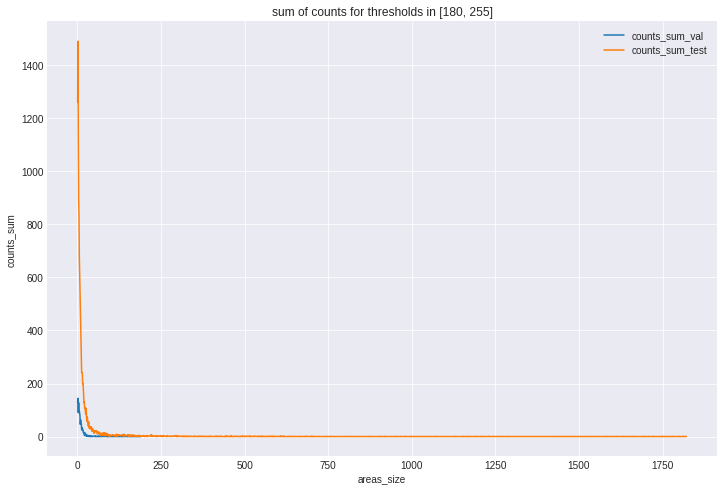

In [19]:
plt.figure(figsize=(12,8))
plt.plot(areas_val, counts_sum_val, label="counts_sum_val")
plt.plot(areas_test, counts_sum_test, label="counts_sum_test")
# plt.bar(areas, counts_sum) # TRY !!!
plt.xlabel("areas_size")
plt.ylabel("counts_sum")
plt.title("sum of counts for thresholds in [{}, {}]".format(th_min, th_max))
plt.xlim([0,200])
plt.legend()
plt.show()

## Investigate area_size counts for specific thresholds

In [ ]:
def plot_area_distro_for_multiple_thresholds(resmaps, thresholds_to_plot, th_min, nbins=200, method="line", title=None):    
    # fix range so that counts have the save x value
    max_area = get_max_area(resmaps, th_min)
    range_area = (0.5 , float(max_area)+0.5)
    
    # compute residual maps for multiple thresholds
    fig = plt.figure(figsize=(12, 5))
    for threshold in thresholds_to_plot:
        resmaps_th = threshold_images(resmaps, threshold)[:,:,:,0]
        resmaps_labeled, areas_all_val = label_images(resmaps_th)
        areas_all_1d = [item for sublist in areas_all_val for item in sublist]       
        
        if method == "hist":            
            count, bins, ignored = plt.hist(
                areas_all_1d,
                bins=nbins,
                density=False,
                range=range_area, # previously commented
                histtype="barstacked",
                label="threshold = {}".format(threshold),
            )
        
        elif method == "line":
            count, bins = np.histogram(
                areas_all_1d, 
                bins=nbins, 
                density=False, 
                range=range_area # previously commented
            )
            bins_middle = bins[:-1] + ((bins[1] - bins[0]) / 2)
            plt.plot(
                bins_middle,
                count,
                linestyle="-",
                linewidth=0.5, # 0.5
                marker="x", # "o"
                markersize=0.5, # 0.5
                label="threshold = {}".format(threshold),
            )
            # plt.fill_between(bins_middle, count)
    
    plt.title(title)
    plt.legend()
    plt.xlabel("area size in pixel")
    plt.ylabel("count")
    plt.grid()
    plt.show()
    return bins, count

In [ ]:
thresholds_to_plot = [180,200,220] # [129, 135, 137, 139, 141]
title_val = "Distribution of anomaly areas' sizes for validation ResMaps with various Thresholds"
bins_val, count_val = plot_area_distro_for_multiple_thresholds(resmaps_val, thresholds_to_plot, th_min, nbins=400, method="line", title=title_val)

In [ ]:
thresholds_to_plot = [180,200,220] # [129, 135, 137, 139, 141]
title_test = "Distribution of anomaly areas' sizes for test ResMaps with various Thresholds"
bins_test, count_test = plot_area_distro_for_multiple_thresholds(resmaps_test, thresholds_to_plot, th_min, nbins=400, method="hist", title=title_test)